# Coiled Failcase for using xhistogram on cmip6 data

## What am I trying to achieve here

I would like to compute a joint distribution (2D histogram) of ocean volume based on values of temperature `thetao` and salinity `so`. 
This requires to take the histogram over the 3 spatial dimensions of e.g. ocean model output (`x`, `y`, and `lev`), preserving the `time` dimension.

The following function is a simple wrapper around `histogram` that provides some inputs (with hardcoded names used for my particular dataset).

Importantly the histogram is weighted by the volume of the cells, so it represents the total volume of the ocean found in a certain bin-combo of temperature and salinity.

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
cluster

In [2]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.28847d0519934706b68f7d4e56b78bb9 Dashboard: /services/dask-gateway/clusters/prod.28847d0519934706b68f7d4e56b78bb9/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
from xhistogram.xarray import histogram
import xarray as xr
import numpy as np
import dask.array as dsa
from dask.distributed import performance_report

## Main Tweaking parameters

In [5]:
n_bins=150 # the number of bins (for each variable). Determines the output chunk size
ct = 2 #chunking along the time dimension (which is preserved in the computation). This determines the size of the input chunks

In [6]:
def pdf_wrapper(ds, bins_dict={'thetao':np.linspace(-1, 1, n_bins), 'so':np.linspace(-1, 1, n_bins)}, dim=['x', 'y', 'lev']):
    
    variables = list(bins_dict.keys())
    
    missing_vars = [var for var in variables if var not in ds.data_vars]
    if len(missing_vars) > 0:
        raise ValueError(f'Bins defined for {missing_vars} in `bins_dict` could not be found in dataset variables {list(ds.data_vars)}')
    
        
    ds = ds.squeeze()
    args = tuple([ds[v] for v in variables])
    bins = [bins_dict[v] for v in variables]
    bin_names = [v+'_bin' for v in variables]
    
    vol = ds.areacello * ds.thkcello

    hist = histogram(*args, bins=bins, weights=vol, dim=dim)
    pdf = hist#/hist.sum(bin_names) # normalize by the full volume
    return pdf

In [7]:
# lets create an artificial dataset for testing (this is on the lower end of resolutions for the CMIP6 data)

nx,ny,nz,nt = 360, 291, 45, 1980
# first try it with consistent chunk sizes (the actual datases can have slightly different time chunks)
cx,cy,cz = nx, ny, nz

so = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
thetao = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
areacello = xr.DataArray(dsa.random.random([nx,ny], chunks=[cx,cy]), dims=['x', 'y'])
thkcello = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
llon, llat = np.meshgrid(np.linspace(0,360, nx), np.linspace(-90,90, ny), indexing='ij')
lon = xr.DataArray(llon, dims=['x','y'])
lat = xr.DataArray(llat, dims=['x','y'])


ds_synth = xr.Dataset({'thetao':thetao, 'so':so})
ds_synth = ds_synth.assign_coords(areacello=areacello, thkcello=thkcello, lon=lon, lat=lat)

# ds_synth = 
ds_synth

<xarray.Dataset>
Dimensions:    (lev: 45, time: 1980, x: 360, y: 291)
Coordinates:
    areacello  (x, y) float64 dask.array<chunksize=(360, 291), meta=np.ndarray>
    thkcello   (x, y, lev, time) float64 dask.array<chunksize=(360, 291, 45, 2), meta=np.ndarray>
    lon        (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0 360.0
    lat        (x, y) float64 -90.0 -89.38 -88.76 -88.14 ... 88.76 89.38 90.0
Dimensions without coordinates: lev, time, x, y
Data variables:
    thetao     (x, y, lev, time) float64 dask.array<chunksize=(360, 291, 45, 2), meta=np.ndarray>
    so         (x, y, lev, time) float64 dask.array<chunksize=(360, 291, 45, 2), meta=np.ndarray>

In [8]:
out = pdf_wrapper(ds_synth).to_dataset(name='test')
out

<xarray.Dataset>
Dimensions:     (so_bin: 149, thetao_bin: 149, time: 1980)
Coordinates:
  * thetao_bin  (thetao_bin) float64 -0.9933 -0.9799 -0.9664 ... 0.9799 0.9933
  * so_bin      (so_bin) float64 -0.9933 -0.9799 -0.9664 ... 0.9799 0.9933
Dimensions without coordinates: time
Data variables:
    test        (time, thetao_bin, so_bin) float64 dask.array<chunksize=(2, 149, 149), meta=np.ndarray>

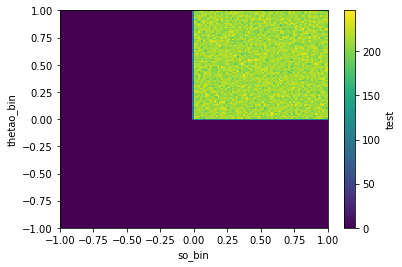

In [9]:
out.test.isel(time=0).plot()

In [18]:
# Set up pangeo scratch bucket
import os
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# -> gs://pangeo-scratch/<username>
import fsspec
mapper_short = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-short.zarr')
mapper_full = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-full.zarr')
mapper_full_nospill = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-full-nospill.zarr')

In [13]:
with performance_report(filename="2d-histogram-dask-report-short.html"):
    out.isel(time=slice(0,500)).to_zarr(mapper_short, mode='w')

In [14]:
with performance_report(filename="2d-histogram-dask-report-full.html"):
    out.to_zarr(mapper_full, mode='w')

In [19]:
# suggested in https://github.com/ocean-transport/coiled_collaboration/issues/8
import dask
with dask.config.set({"distributed.worker.memory.spill": None}):
    with performance_report(filename="2d-histogram-dask-report-full-nospill.html"):
        out.to_zarr(mapper_full_nospill, mode='w')